# Context
In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.

# Content
The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation








In [1]:
import numpy as np

# Data management and training
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline, Pipeline

# Scoring and evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC

# Model export / import
import joblib

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

#Preparing and analysing the dataset

In [2]:
stellar_data = pd.read_csv("https://raw.githubusercontent.com/MercyTheHunter/MachineLearning_Stellar_class/main/star_classification.csv?token=GHSAT0AAAAAACKA2SVN3OXWBXDZBRCSCCOMZKLJQNQ")
stellar_data[:10]

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   
5  1.237680e+18  340.995121  20.589476  23.48827  23.33776  21.32195   
6  1.237679e+18   23.234926  11.418188  21.46973  21.17624  20.92829   
7  1.237679e+18    5.433176  12.065186  22.24979  22.02172  20.34126   
8  1.237661e+18  200.290475  47.199402  24.40286  22.35669  20.61032   
9  1.237671e+18   39.149691  28.102842  21.74669  20.03493  19.17553   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   
5  20.25615  19.54544    8102       301        3       110  5.658977e+18   
6  20.60826  20.42573    7773       301        2       462  1.246262e+19   
7  19.48794  18.84999    7773       301        2       346  6.961443e+18   
8  19.46490  18.95852    3716       301        5       108  7.459285e+18   
9  18.81823  18.65422    5934       301        4       122  2.751763e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842  
5     QSO  1.424659   5026  55855       741  
6     QSO  0.586455  11069  58456       113  
7  GALAXY  0.477009   6183  56210        15  
8  GALAXY  0.660012   6625  56386       719  
9    STAR -0.000008   2444  54082       232

In [3]:
stellar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [4]:
stellar_data.describe().T

count          mean           std           min           25%  \
obj_ID       100000.0  1.237665e+18  8.438560e+12  1.237646e+18  1.237659e+18   
alpha        100000.0  1.776291e+02  9.650224e+01  5.527828e-03  1.275182e+02   
delta        100000.0  2.413530e+01  1.964467e+01 -1.878533e+01  5.146771e+00   
u            100000.0  2.198047e+01  3.176929e+01 -9.999000e+03  2.035235e+01   
g            100000.0  2.053139e+01  3.175029e+01 -9.999000e+03  1.896523e+01   
r            100000.0  1.964576e+01  1.854760e+00  9.822070e+00  1.813583e+01   
i            100000.0  1.908485e+01  1.757895e+00  9.469903e+00  1.773228e+01   
z            100000.0  1.866881e+01  3.172815e+01 -9.999000e+03  1.746068e+01   
run_ID       100000.0  4.481366e+03  1.964765e+03  1.090000e+02  3.187000e+03   
rerun_ID     100000.0  3.010000e+02  0.000000e+00  3.010000e+02  3.010000e+02   
cam_col      100000.0  3.511610e+00  1.586912e+00  1.000000e+00  2.000000e+00   
field_ID     100000.0  1.861305e+02  1.490111e+02  1.100000e+01  8.200000e+01   
spec_obj_ID  100000.0  5.783882e+18  3.324016e+18  2.995191e+17  2.844138e+18   
redshift     100000.0  5.766608e-01  7.307073e-01 -9.970667e-03  5.451684e-02   
plate        100000.0  5.137010e+03  2.952303e+03  2.660000e+02  2.526000e+03   
MJD          100000.0  5.558865e+04  1.808484e+03  5.160800e+04  5.423400e+04   
fiber_ID     100000.0  4.493127e+02  2.724984e+02  1.000000e+00  2.210000e+02   

                      50%           75%           max  
obj_ID       1.237663e+18  1.237668e+18  1.237681e+18  
alpha        1.809007e+02  2.338950e+02  3.599998e+02  
delta        2.364592e+01  3.990155e+01  8.300052e+01  
u            2.217914e+01  2.368744e+01  3.278139e+01  
g            2.109983e+01  2.212377e+01  3.160224e+01  
r            2.012529e+01  2.104478e+01  2.957186e+01  
i            1.940514e+01  2.039650e+01  3.214147e+01  
z            1.900460e+01  1.992112e+01  2.938374e+01  
run_ID       4.188000e+03  5.326000e+03  8.162000e+03  
rerun_ID     3.010000e+02  3.010000e+02  3.010000e+02  
cam_col      4.000000e+00  5.000000e+00  6.000000e+00  
field_ID     1.460000e+02  2.410000e+02  9.890000e+02  
spec_obj_ID  5.614883e+18  8.332144e+18  1.412694e+19  
redshift     4.241733e-01  7.041543e-01  7.011245e+00  
plate        4.987000e+03  7.400250e+03  1.254700e+04  
MJD          5.586850e+04  5.677700e+04  5.893200e+04  
fiber_ID     4.330000e+02  6.450000e+02  1.000000e+03

In [ ]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=stellar_data["redshift"], name="Redshift Box Plot", boxmean=True)
tr2=go.Histogram(x=stellar_data["redshift"], name="Redshift Histogram")

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_layout(height=800, width=1500, title_text="Redshift distribution")
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=stellar_data["plate"], name="Plate Box Plot", boxmean=True)
tr2=go.Histogram(x=stellar_data["plate"], name="Plate Histogram")

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_layout(height=800, width=1500, title_text="Plate distribution")
fig.show()

In [ ]:
ex.pie(stellar_data, names="class", title="Proportions of different classes")

In [ ]:
thin_stellar_data = stellar_data.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'],axis=1)
pears_mtx = thin_stellar_data.corr("pearson")
pears_mtx

u         g         r         i         z  spec_obj_ID  \
u            1.000000  0.999311  0.054149  0.045730  0.998093     0.029997   
g            0.999311  1.000000  0.062387  0.056271  0.999161     0.039443   
r            0.054149  0.062387  1.000000  0.962868  0.053677     0.655245   
i            0.045730  0.056271  0.962868  1.000000  0.055994     0.661641   
z            0.998093  0.999161  0.053677  0.055994  1.000000     0.037813   
spec_obj_ID  0.029997  0.039443  0.655245  0.661641  0.037813     1.000000   
redshift     0.014309  0.022954  0.433241  0.492383  0.030380     0.388642   
plate        0.029997  0.039443  0.655243  0.661640  0.037813     1.000000   
MJD          0.031997  0.040274  0.671180  0.672523  0.037469     0.970167   

             redshift     plate       MJD  
u            0.014309  0.029997  0.031997  
g            0.022954  0.039443  0.040274  
r            0.433241  0.655243  0.671180  
i            0.492383  0.661640  0.672523  
z            0.030380  0.037813  0.037469  
spec_obj_ID  0.388642  1.000000  0.970167  
redshift     1.000000  0.388641  0.387109  
plate        0.388641  1.000000  0.970166  
MJD          0.387109  0.970166  1.000000

In [ ]:
spearm_mtx = thin_stellar_data.corr("spearman")
spearm_mtx

u         g         r         i         z  spec_obj_ID  \
u            1.000000  0.849836  0.688531  0.562918  0.495295     0.405987   
g            0.849836  1.000000  0.906117  0.789512  0.716969     0.581851   
r            0.688531  0.906117  1.000000  0.957717  0.909862     0.675802   
i            0.562918  0.789512  0.957717  1.000000  0.978038     0.683901   
z            0.495295  0.716969  0.909862  0.978038  1.000000     0.663915   
spec_obj_ID  0.405987  0.581851  0.675802  0.683901  0.663915     1.000000   
redshift     0.331137  0.510181  0.572910  0.582434  0.569860     0.491777   
plate        0.405988  0.581851  0.675802  0.683901  0.663915     1.000000   
MJD          0.406383  0.581213  0.673797  0.681097  0.660379     0.992143   

             redshift     plate       MJD  
u            0.331137  0.405988  0.406383  
g            0.510181  0.581851  0.581213  
r            0.572910  0.675802  0.673797  
i            0.582434  0.683901  0.681097  
z            0.569860  0.663915  0.660379  
spec_obj_ID  0.491777  1.000000  0.992143  
redshift     1.000000  0.491777  0.489696  
plate        0.491777  1.000000  0.992143  
MJD          0.489696  0.992143  1.000000

In [ ]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Pearson Correlation", "Spearman Correlation"))

pears_idx = pears_mtx.index
pears_col = pears_mtx.columns
pears_val = pears_mtx.values
fig.add_trace(go.Heatmap(x=pears_col, y=pears_idx, z=pears_val, name='pearson', showscale=False, xgap=0.9, ygap=0.9), row=1, col=1)

spearm_idx = spearm_mtx.index
spearm_col = spearm_mtx.columns
spearm_val = spearm_mtx.values
fig.add_trace(go.Heatmap(x=spearm_col, y=spearm_idx, z=spearm_val, name='spearman', xgap=0.9, ygap=0.9), row=2, col=1)

fig.update_layout(height=800, width=1500, title_text="Numeric Correlations")
fig.show()

#Splitting the data to train and test our models

In [5]:
X = stellar_data.drop("class",axis=1)
X[:10]

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   
5  1.237680e+18  340.995121  20.589476  23.48827  23.33776  21.32195   
6  1.237679e+18   23.234926  11.418188  21.46973  21.17624  20.92829   
7  1.237679e+18    5.433176  12.065186  22.24979  22.02172  20.34126   
8  1.237661e+18  200.290475  47.199402  24.40286  22.35669  20.61032   
9  1.237671e+18   39.149691  28.102842  21.74669  20.03493  19.17553   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   
5  20.25615  19.54544    8102       301        3       110  5.658977e+18   
6  20.60826  20.42573    7773       301        2       462  1.246262e+19   
7  19.48794  18.84999    7773       301        2       346  6.961443e+18   
8  19.46490  18.95852    3716       301        5       108  7.459285e+18   
9  18.81823  18.65422    5934       301        4       122  2.751763e+18   

   redshift  plate    MJD  fiber_ID  
0  0.634794   5812  56354       171  
1  0.779136  10445  58158       427  
2  0.644195   4576  55592       299  
3  0.932346   9149  58039       775  
4  0.116123   6121  56187       842  
5  1.424659   5026  55855       741  
6  0.586455  11069  58456       113  
7  0.477009   6183  56210        15  
8  0.660012   6625  56386       719  
9 -0.000008   2444  54082       232

In [6]:
y = stellar_data["class"]
y[:10]

0    GALAXY
1    GALAXY
2    GALAXY
3    GALAXY
4    GALAXY
5       QSO
6       QSO
7    GALAXY
8    GALAXY
9      STAR
Name: class, dtype: object

In [7]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [8]:
#Balance the data
oversampler = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

In [9]:
X_train.head()

obj_ID       alpha      delta         u         g         r  \
76513  1.237658e+18  130.932167   4.313411  20.13070  18.37146  17.49792   
60406  1.237662e+18  225.429599  33.172083  19.86315  18.93886  18.59344   
27322  1.237659e+18  219.173525  55.511740  19.84785  17.60157  16.71511   
53699  1.237665e+18  178.735461  36.044139  17.83635  16.47576  15.82407   
65412  1.237668e+18  192.807458  18.727770  24.27039  22.60266  20.47710   

              i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
76513  17.06977  16.77949    3015       301        3       112  1.337614e+18   
60406  18.46922  18.40977    3900       301        5       594  3.304619e+18   
27322  16.41555  16.25413    3225       301        4        74  3.711097e+18   
53699  15.45751  15.18434    4552       301        6        67  2.367855e+18   
65412  19.45898  19.08250    5314       301        1       105  6.596788e+18   

       redshift  plate    MJD  fiber_ID  
76513  0.155863   1188  52650       165  
60406 -0.000529   2935  54652       374  
27322 -0.000261   3296  54909       475  
53699  0.068444   2103  53467       317  
65412  0.540778   5859  56065       510

In [10]:
X_train_smote.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237658e+18  130.932167   4.313411  20.13070  18.37146  17.49792   
1  1.237662e+18  225.429599  33.172083  19.86315  18.93886  18.59344   
2  1.237659e+18  219.173525  55.511740  19.84785  17.60157  16.71511   
3  1.237665e+18  178.735461  36.044139  17.83635  16.47576  15.82407   
4  1.237668e+18  192.807458  18.727770  24.27039  22.60266  20.47710   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  17.06977  16.77949    3015       301        3       112  1.337614e+18   
1  18.46922  18.40977    3900       301        5       594  3.304619e+18   
2  16.41555  16.25413    3225       301        4        74  3.711097e+18   
3  15.45751  15.18434    4552       301        6        67  2.367855e+18   
4  19.45898  19.08250    5314       301        1       105  6.596788e+18   

   redshift  plate    MJD  fiber_ID  
0  0.155863   1188  52650       165  
1 -0.000529   2935  54652       374  
2 -0.000261   3296  54909       475  
3  0.068444   2103  53467       317  
4  0.540778   5859  56065       510

In [11]:
y_train.head()

76513    GALAXY
60406      STAR
27322      STAR
53699    GALAXY
65412    GALAXY
Name: class, dtype: object

In [12]:
y_train_smote.head()

0    GALAXY
1      STAR
2      STAR
3    GALAXY
4    GALAXY
Name: class, dtype: object

In [ ]:
X_train.shape, X_test.shape, X_train_smote.shape, y_train.shape, y_test.shape, y_train_smote.shape

((70000, 17), (30000, 17), (124800, 17), (70000,), (30000,), (124800,))

#Initial fitting and scoring of models

In [ ]:
models = {"RFC": RandomForestClassifier(),
          "LSVC": LinearSVC(),
          "KNNC": KNeighborsClassifier(),
          "SVC": SVC(),
          "LR": LogisticRegression()}

In [ ]:
def fit_and_score(models,X_train,X_test,y_train,y_test):
    """
    Fits and evaulates the given models : these are in a dictionary.
    X_train : training data
    X_test : testing data
    y_train : training labels
    y_test : testing labels
    """
    np.random.seed(42)

    # to keep model scores
    model_scores = {}

    # loop through models
    for name, model in models.items():
        # fit the model
        model.fit(X_train,y_train)
        # evaluate it
        score = model.score(X_test,y_test)
        model_scores[name] = score
    return model_scores


In [ ]:
model_scores = fit_and_score(models = models,
                             X_train = X_train_smote,
                             X_test = X_test,
                             y_train = y_train_smote,
                             y_test = y_test)

In [ ]:
model_scores

{'RFC': 0.9757333333333333,
 'LSVC': 0.5948333333333333,
 'KNNC': 0.6625,
 'SVC': 0.48593333333333333,
 'LR': 0.3611333333333333}

<Axes: >

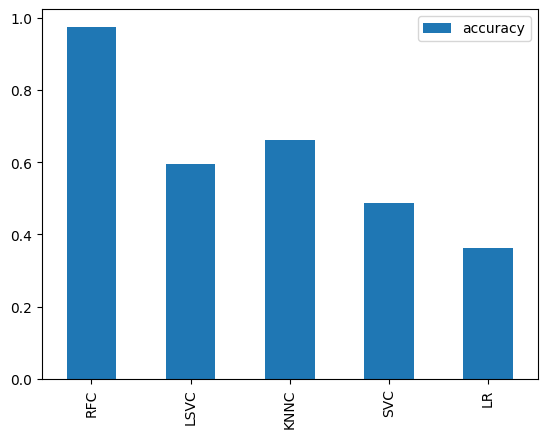

In [ ]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()

In [ ]:
sgd_models = {
    "SVM" : make_pipeline(StandardScaler(), SGDClassifier(loss='hinge', random_state=42)),
    "Logistic" : make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', random_state=42)),
    "Modified Huber" : make_pipeline(StandardScaler(), SGDClassifier(loss='modified_huber', random_state=42)),
    "Squared Hinge" : make_pipeline(StandardScaler(), SGDClassifier(loss='squared_hinge', random_state=42)),
    "Perceptron" : make_pipeline(StandardScaler(), SGDClassifier(loss='perceptron', random_state=42))
}

In [ ]:
sgd_model_scores = fit_and_score(models = sgd_models,
                             X_train = X_train_smote,
                             X_test = X_test,
                             y_train = y_train_smote,
                             y_test = y_test)

In [ ]:
sgd_model_scores

{'SVM': 0.8939666666666667,
 'Logistic': 0.8954333333333333,
 'Modified Huber': 0.9194666666666667,
 'Squared Hinge': 0.8814,
 'Perceptron': 0.8739}

<Axes: >

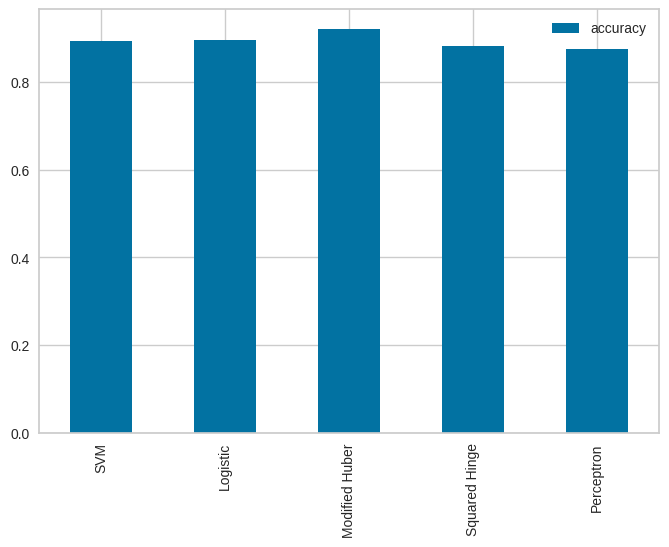

In [ ]:
sgd_model_compare = pd.DataFrame(sgd_model_scores, index=["accuracy"])
sgd_model_compare.T.plot.bar()

#Hyperparameter tuning



##SVC



In [ ]:
#svc_grid = {"C" : [0.1, 1],
#            "gamma" : [1, 0.1],
#            "kernel" : ['rbf']}
np.random.seed(42)

rs_svc = RandomizedSearchCV(SVC(),
                            param_distributions=svc_grid,
                            cv=5,
                            n_iter=20,
                            refit=True,
                            verbose=True)
rs_svc.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
#rs_svc.best_params_

In [ ]:
#rs_svc.score(X_test,y_test)

In [ ]:
#clf1 = SVC(C=1, kernel='rbf')
#clf1.fit(X_train_smote, y_train_smote)

In [ ]:
#joblib.dump(clf1,"stellar_classification_SVC.pkl")



##Logistic Regression



In [ ]:
log_reg_grid = {"C": np.logspace(-5,5,50),
                "solver": ["liblinear"]}
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                refit=True,
                                verbose=True)
rs_log_reg.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-0...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [ ]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.004498432668969444}

In [ ]:
rs_log_reg.score(X_test,y_test)

0.3159

In [ ]:
clf2 = LogisticRegression(C=0.004498432668969444, solver='liblinear')
clf2.fit(X_train_smote,y_train_smote)

LogisticRegression(C=0.004498432668969444, solver='liblinear')

In [ ]:
joblib.dump(clf2,"stellar_classification_LR.pkl")

['stellar_classification_LR.pkl']



##KNN



In [ ]:
#setup
train_scores = []
test_scores = []
score_diffs = []
neighbors = np.arange(1,21)
KNN = KNeighborsClassifier()

#tuning (loop: set params -> fit -> train -> test -> save)
for i in neighbors:
  #setting the params
  KNN.set_params(n_neighbors = i)

  #fitting the model
  KNN.fit(X_train_smote, y_train_smote)

  #training scores
  train_score = KNN.score(X_train_smote, y_train_smote)

  #testing scores
  test_score = KNN.score(X_test, y_test)

  #score difference
  score_diff = abs(train_score - test_score)
  #saving
  train_scores.append(train_score)
  test_scores.append(test_score)
  score_diffs.append(score_diff)

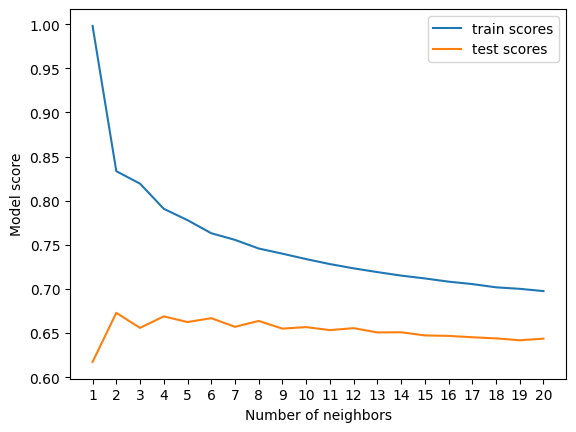

In [ ]:
plt.plot(neighbors, train_scores, label="train scores")
plt.plot(neighbors, test_scores, label="test scores")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

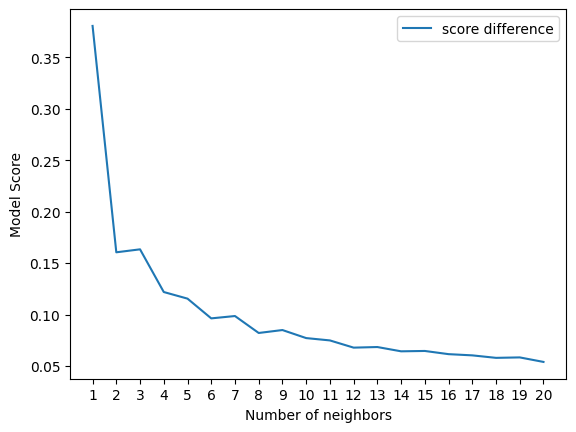

In [ ]:
plt.plot(neighbors, score_diffs, label="score difference")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model Score")
plt.legend()

In [ ]:
clf3 = KNeighborsClassifier(n_neighbors = 20)
clf3.fit(X_train_smote,y_train_smote)

KNeighborsClassifier(n_neighbors=20)

In [ ]:
joblib.dump(clf3,"stellar_classification_KNN.pkl")

['stellar_classification_KNN.pkl']



##Random Forest Classifier



In [ ]:
rf_grid = {"n_estimators": np.arange(10,100,10),
           "max_depth": [2,3,5],
           "min_samples_split": np.arange(2,10,1),
           "min_samples_leaf": np.arange(1,10,1)}
np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                            param_distributions=rf_grid,
                            cv=5,
                            n_iter=50,
                            refit=True,
                            verbose=True)
rs_rf.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': [2, 3, 5],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [ ]:
rs_rf.best_params_

{'n_estimators': 30,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_depth': 5}

In [ ]:
rs_rf.score(X_test,y_test)

0.9592

In [ ]:
clf4 = RandomForestClassifier(n_estimators = 30, max_depth = 5, min_samples_split = 9, min_samples_leaf = 2)
clf4.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=9,
                       n_estimators=30)

In [ ]:
joblib.dump(clf4,"stellar_classification_RF.pkl")

['stellar_classification_RF.pkl']

##SGDClassifier

In [ ]:
rf_grid = {"clf__penalty": ["l2", "l1", "elasticnet"],
           "clf__l1_ratio": np.arange(0.15,1,0.05),
           "clf__max_iter": np.arange(500,2000,100),
           "clf__loss" : ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber"],
           "clf__average" : [True, False]}
np.random.seed(42)

steps = [('scaler', StandardScaler()), ("clf", SGDClassifier(random_state=42))]
rs_rf = RandomizedSearchCV(Pipeline(steps),
                            param_distributions=rf_grid,
                            n_jobs=4,
                            cv=5,
                            n_iter=100,
                            refit=True,
                            verbose=4)
rs_rf.fit(X_train_smote,y_train_smote)

## Ran for 2 hours

In [ ]:
rs_rf.best_params_

# output:
# {'clf__penalty': 'l1',
#  'clf__max_iter': 1000,
#  'clf__loss': 'squared_hinge',
#  'clf__l1_ratio': 0.9500000000000003,
#  'clf__average': True}

In [ ]:
rs_rf.score(X_test,y_test)

#output: 0.951

In [ ]:
clf5 = make_pipeline(StandardScaler(), SGDClassifier(loss='squared_hinge', random_state=42, penalty="l1", max_iter=1000, l1_ratio=0.95, average=True))
clf5.fit(X_train_smote, y_train_smote)

#Evaluation and scoring

##Import the saved models

In [ ]:
#SVC
#trained_SVC = joblib.load("stellar_classification_SVC.pkl")
#default_SVC = SVC()
#default_SVC.fit(X_train_smote, y_train_smote)

In [ ]:
#Logistic Regression
trained_LR = joblib.load("stellar_classification_LR.pkl")
default_LR = LogisticRegression()
default_LR.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [ ]:
#KNN
trained_KNN = joblib.load("stellar_classification_KNN.pkl")
default_KNN = KNeighborsClassifier()
default_KNN.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [ ]:
#Random Forest
trained_RF = joblib.load("stellar_classification_RF.pkl")
default_RF = RandomForestClassifier()
default_RF.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [ ]:
#SGD
trained_SGD = joblib.load("stellar_classification_SGD.pkl")
default_SGD = make_pipeline(StandardScaler(), SGDClassifier(random_state=42))
default_SGD.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=42))])

##Predictions and confusion matrices

###SVC


In [ ]:
#SVC
#y_preds_trained_SVC = trained_SVC.predict(X_test)
#y_preds_default_SVC = default_SVC.predict(X_test)
#confusion_matrix_trained_SVC = confusion_matrix(y_test, y_preds_trained_SVC)
#confusion_matrix_default_SVC = confusion_matrix(y_test, y_preds_default_SVC)

NameError: ignored

In [ ]:
#confusion_matrix_trained_SVC

In [ ]:
confusion_matrix_default_SVC

NameError: ignored

In [ ]:
#confusion_matrix_trained_SVC_display = ConfusionMatrix(trained_SVC, classes=['GALAXY','STAR','QSO'])

#confusion_matrix_trained_SVC_display.fit(X_train_smote, y_train_smote)
#confusion_matrix_trained_SVC_display.score(X_test, y_test)
#confusion_matrix_trained_SVC_display.show()

In [ ]:
confusion_matrix_default_SVC_display = ConfusionMatrix(default_SVC, classes=['GALAXY','STAR','QSO'])

confusion_matrix_default_SVC_display.fit(X_train_smote, y_train_smote)
confusion_matrix_default_SVC_display.score(X_test, y_test)
confusion_matrix_default_SVC_display.show()

###Logistic Regression

In [ ]:
#Logistic Regression
y_preds_trained_LR = trained_LR.predict(X_test)
y_preds_default_LR = default_LR.predict(X_test)
confusion_matrix_trained_LR = confusion_matrix(y_test, y_preds_trained_LR)
confusion_matrix_default_LR = confusion_matrix(y_test, y_preds_default_LR)

In [ ]:
confusion_matrix_trained_LR

array([[1374, 7265, 9206],
       [ 354, 3940, 1406],
       [ 349, 1943, 4163]])

In [ ]:
confusion_matrix_default_LR

array([[2965, 6712, 8168],
       [ 658, 3853, 1189],
       [ 561, 1878, 4016]])

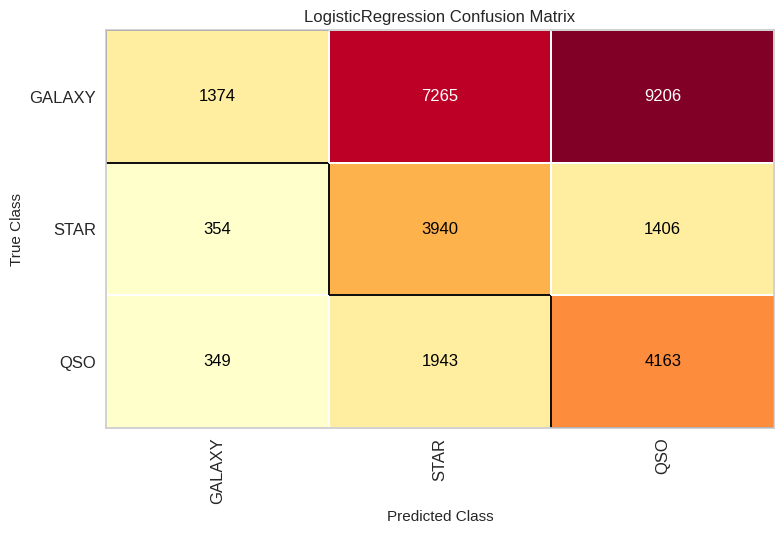

<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_trained_LR_display = ConfusionMatrix(trained_LR, classes=['GALAXY','STAR','QSO'])

confusion_matrix_trained_LR_display.fit(X_train_smote, y_train_smote)
confusion_matrix_trained_LR_display.score(X_test, y_test)
confusion_matrix_trained_LR_display.show()

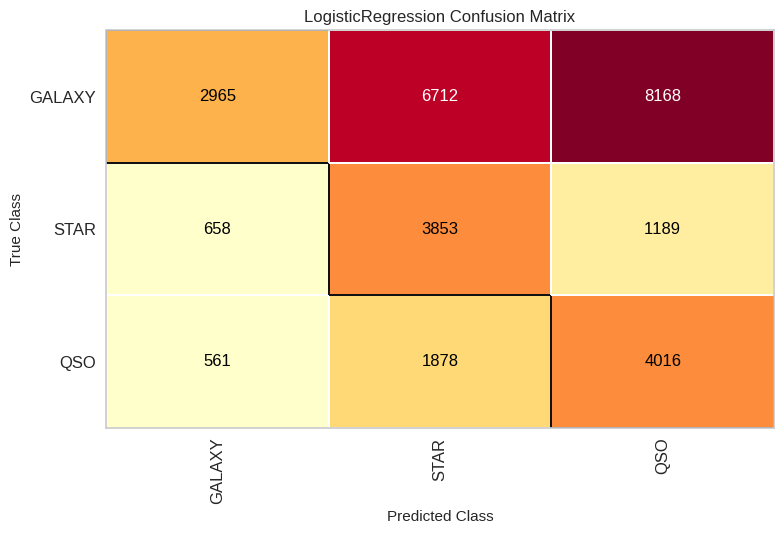

<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_default_LR_display = ConfusionMatrix(default_LR, classes=['GALAXY','STAR','QSO'])

confusion_matrix_default_LR_display.fit(X_train_smote, y_train_smote)
confusion_matrix_default_LR_display.score(X_test, y_test)
confusion_matrix_default_LR_display.show()

###KNN

In [ ]:
#KNN
y_preds_trained_KNN = trained_KNN.predict(X_test)
y_preds_default_KNN = default_KNN.predict(X_test)
confusion_matrix_trained_KNN = confusion_matrix(y_test, y_preds_trained_KNN)
confusion_matrix_default_KNN = confusion_matrix(y_test, y_preds_default_KNN)

In [ ]:
confusion_matrix_trained_KNN

array([[12475,  3509,  1861],
       [ 1608,  3374,   718],
       [ 1527,  1466,  3462]])

In [ ]:
confusion_matrix_default_KNN

array([[13563,  2700,  1582],
       [ 2020,  2914,   766],
       [ 1788,  1269,  3398]])

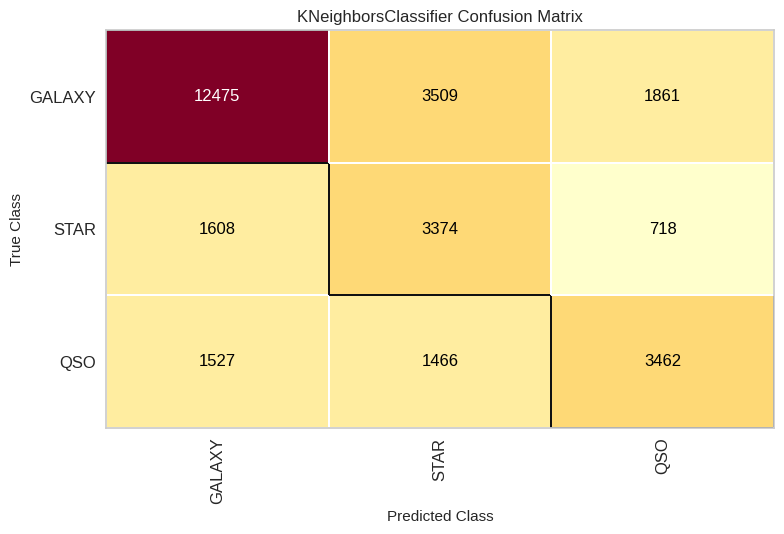

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_trained_KNN_display = ConfusionMatrix(trained_KNN, classes=['GALAXY','STAR','QSO'])

confusion_matrix_trained_KNN_display.fit(X_train_smote, y_train_smote)
confusion_matrix_trained_KNN_display.score(X_test, y_test)
confusion_matrix_trained_KNN_display.show()

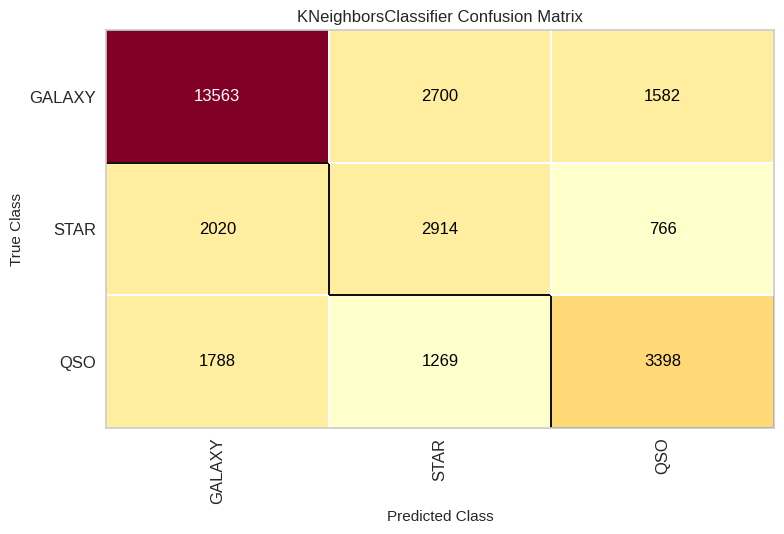

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_default_KNN_display = ConfusionMatrix(default_KNN, classes=['GALAXY','STAR','QSO'])

confusion_matrix_default_KNN_display.fit(X_train_smote, y_train_smote)
confusion_matrix_default_KNN_display.score(X_test, y_test)
confusion_matrix_default_KNN_display.show()

###Random Forest

In [ ]:
#Random Forest
y_preds_trained_RF = trained_RF.predict(X_test)
y_preds_default_RF = default_RF.predict(X_test)
confusion_matrix_trained_RF = confusion_matrix(y_test, y_preds_trained_RF)
confusion_matrix_default_RF = confusion_matrix(y_test, y_preds_default_RF)

In [ ]:
confusion_matrix_trained_RF

array([[16961,   730,   154],
       [  451,  5247,     2],
       [    0,     0,  6455]])

In [ ]:
confusion_matrix_default_RF

array([[17434,   309,   102],
       [  341,  5358,     1],
       [    1,     0,  6454]])

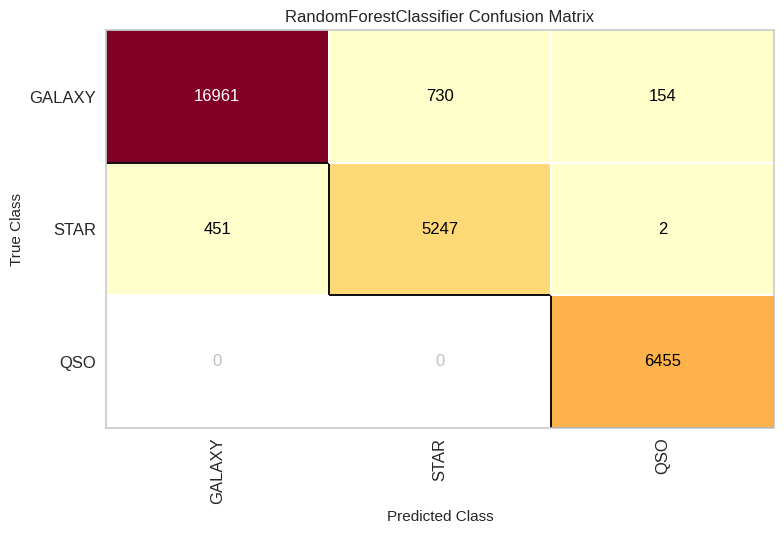

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_trained_RF_display = ConfusionMatrix(trained_RF, classes=['GALAXY','STAR','QSO'])

confusion_matrix_trained_RF_display.fit(X_train_smote, y_train_smote)
confusion_matrix_trained_RF_display.score(X_test, y_test)
confusion_matrix_trained_RF_display.show()

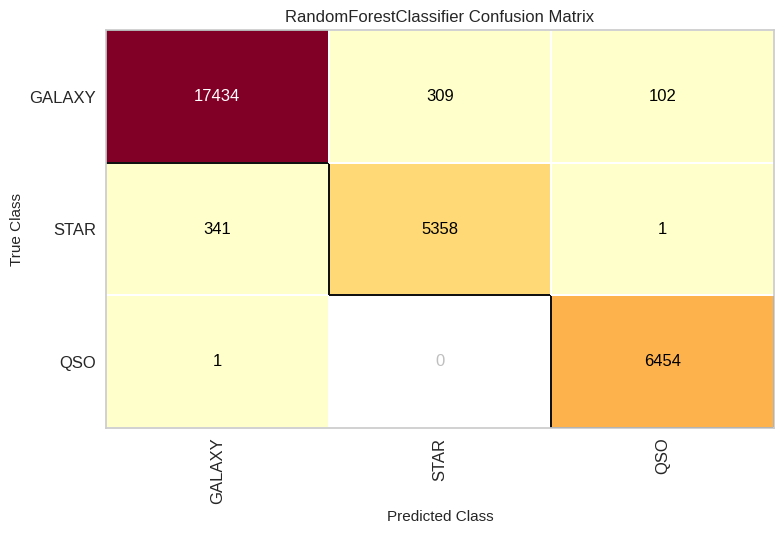

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_default_RF_display = ConfusionMatrix(default_RF, classes=['GALAXY','STAR','QSO'])

confusion_matrix_default_RF_display.fit(X_train_smote, y_train_smote)
confusion_matrix_default_RF_display.score(X_test, y_test)
confusion_matrix_default_RF_display.show()

### SGD Classifier

In [ ]:
y_preds_trained_SGD = trained_SGD.predict(X_test)
y_preds_default_SGD = default_SGD.predict(X_test)
confusion_matrix_trained_SGD = confusion_matrix(y_test, y_preds_trained_SGD)
confusion_matrix_default_SGD = confusion_matrix(y_test, y_preds_default_SGD)

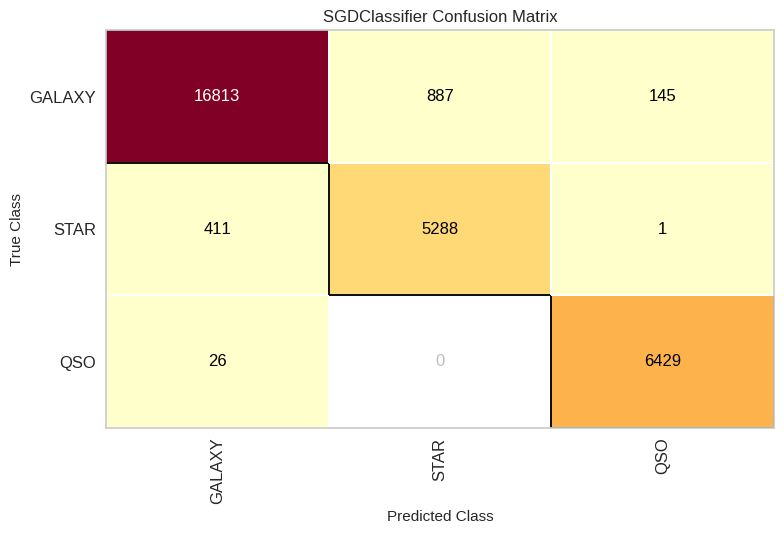

<Axes: title={'center': 'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_trained_SGD_display = ConfusionMatrix(trained_SGD, classes=['GALAXY','STAR','QSO'])

confusion_matrix_trained_SGD_display.fit(X_train_smote, y_train_smote)
confusion_matrix_trained_SGD_display.score(X_test, y_test)
confusion_matrix_trained_SGD_display.show()

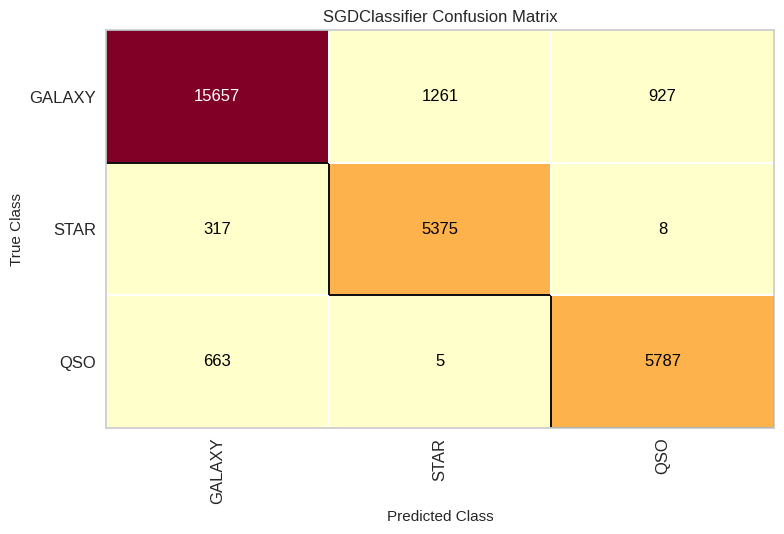

<Axes: title={'center': 'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
confusion_matrix_default_SGD_display = ConfusionMatrix(default_SGD, classes=['GALAXY','STAR','QSO'])

confusion_matrix_default_SGD_display.fit(X_train_smote, y_train_smote)
confusion_matrix_default_SGD_display.score(X_test, y_test)
confusion_matrix_default_SGD_display.show()

##Class prediction error

###SVC

In [ ]:
#class_prediction_error_trained_SVC = ClassPredictionError(trained_SVC, classes=['GALAXY','STAR','QSO'])

#class_prediction_error_trained_SVC.fit(X_train_smote, y_train_smote)
#class_prediction_error_trained_SVC.score(X_test, y_test)
#class_prediction_error_trained_SVC.show()

In [ ]:
#class_prediction_error_default_SVC = ClassPredictionError(default_SVC, classes=['GALAXY','STAR','QSO'])

#class_prediction_error_default_SVC.fit(X_train_smote, y_train_smote)
#class_prediction_error_default_SVC.score(X_test, y_test)
#class_prediction_error_default_SVC.show()

###Logistic Regression

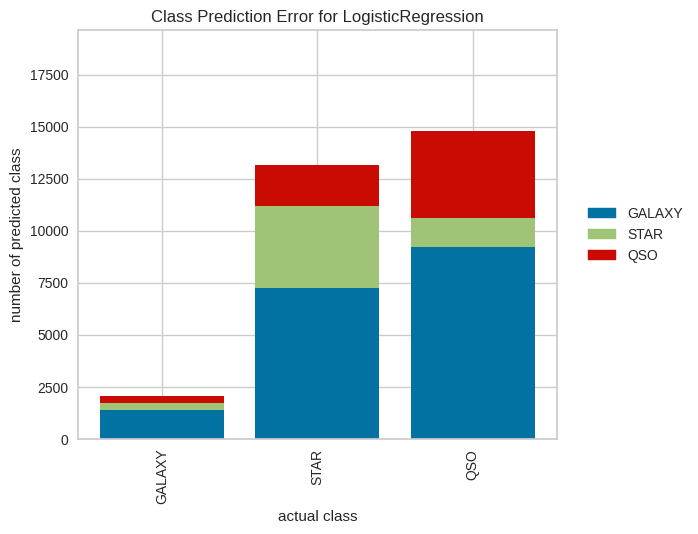

<Axes: title={'center': 'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_trained_LR = ClassPredictionError(trained_LR, classes=['GALAXY','STAR','QSO'])

class_prediction_error_trained_LR.fit(X_train_smote, y_train_smote)
class_prediction_error_trained_LR.score(X_test, y_test)
class_prediction_error_trained_LR.show()

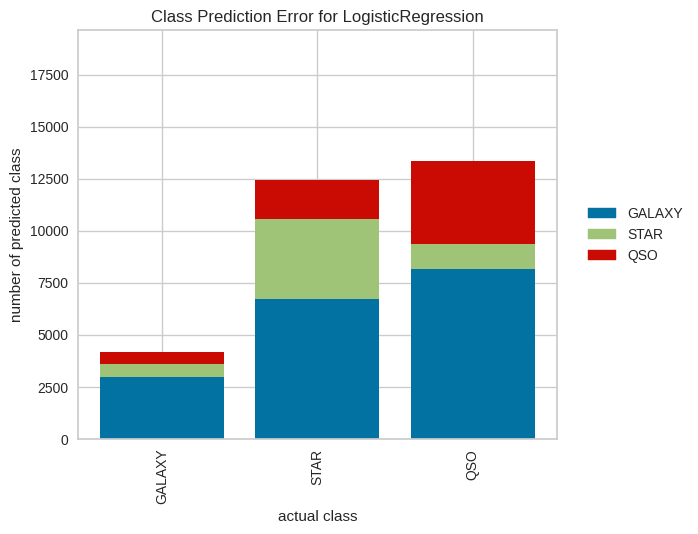

<Axes: title={'center': 'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_default_LR = ClassPredictionError(default_LR, classes=['GALAXY','STAR','QSO'])

class_prediction_error_default_LR.fit(X_train_smote, y_train_smote)
class_prediction_error_default_LR.score(X_test, y_test)
class_prediction_error_default_LR.show()

###KNN

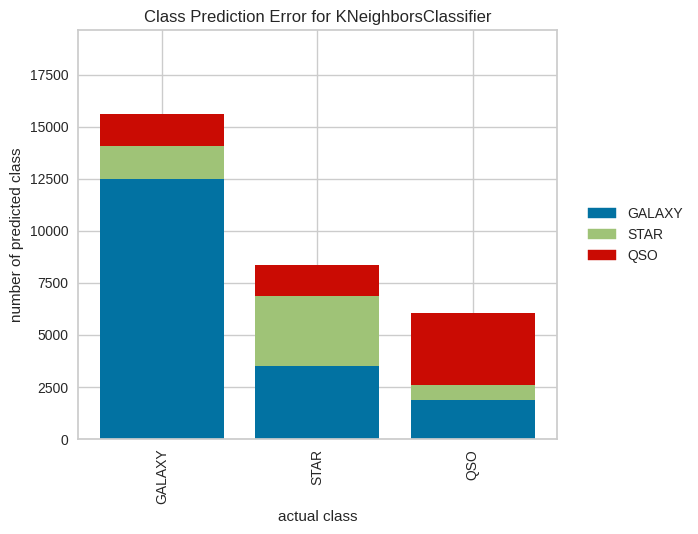

<Axes: title={'center': 'Class Prediction Error for KNeighborsClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_trained_KNN = ClassPredictionError(trained_KNN, classes=['GALAXY','STAR','QSO'])

class_prediction_error_trained_KNN.fit(X_train_smote, y_train_smote)
class_prediction_error_trained_KNN.score(X_test, y_test)
class_prediction_error_trained_KNN.show()

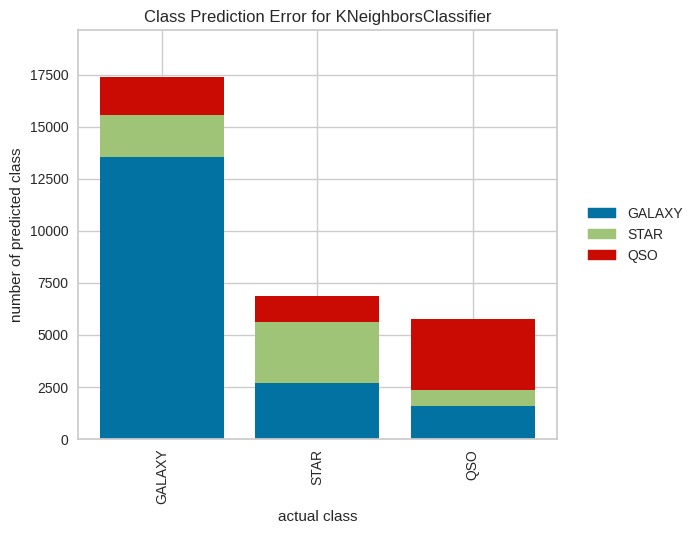

<Axes: title={'center': 'Class Prediction Error for KNeighborsClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_default_KNN = ClassPredictionError(default_KNN, classes=['GALAXY','STAR','QSO'])

class_prediction_error_default_KNN.fit(X_train_smote, y_train_smote)
class_prediction_error_default_KNN.score(X_test, y_test)
class_prediction_error_default_KNN.show()

###Random Forest

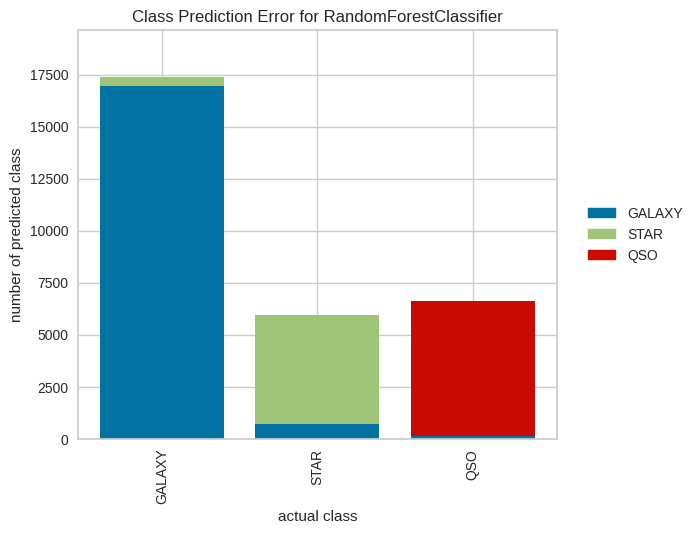

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_trained_RF = ClassPredictionError(trained_RF, classes=['GALAXY','STAR','QSO'])

class_prediction_error_trained_RF.fit(X_train_smote, y_train_smote)
class_prediction_error_trained_RF.score(X_test, y_test)
class_prediction_error_trained_RF.show()

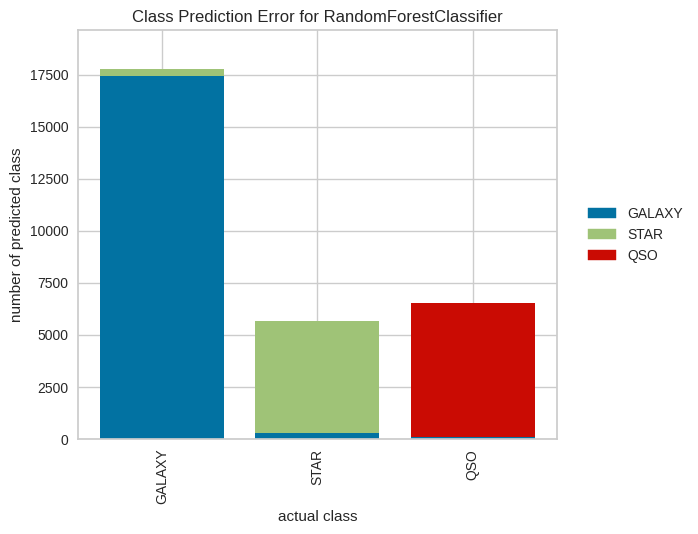

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_default_RF = ClassPredictionError(default_RF, classes=['GALAXY','STAR','QSO'])

class_prediction_error_default_RF.fit(X_train_smote, y_train_smote)
class_prediction_error_default_RF.score(X_test, y_test)
class_prediction_error_default_RF.show()

###SGD Classifier

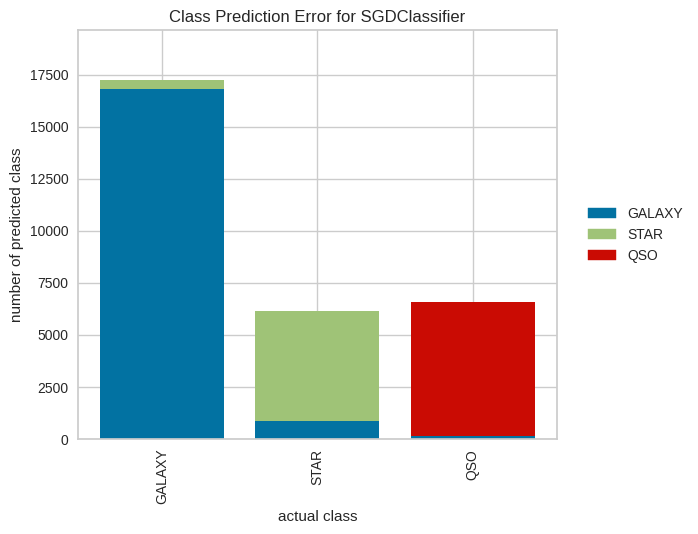

<Axes: title={'center': 'Class Prediction Error for SGDClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_trained_SGD = ClassPredictionError(trained_SGD, classes=['GALAXY','STAR','QSO'])

class_prediction_error_trained_SGD.fit(X_train_smote, y_train_smote)
class_prediction_error_trained_SGD.score(X_test, y_test)
class_prediction_error_trained_SGD.show()

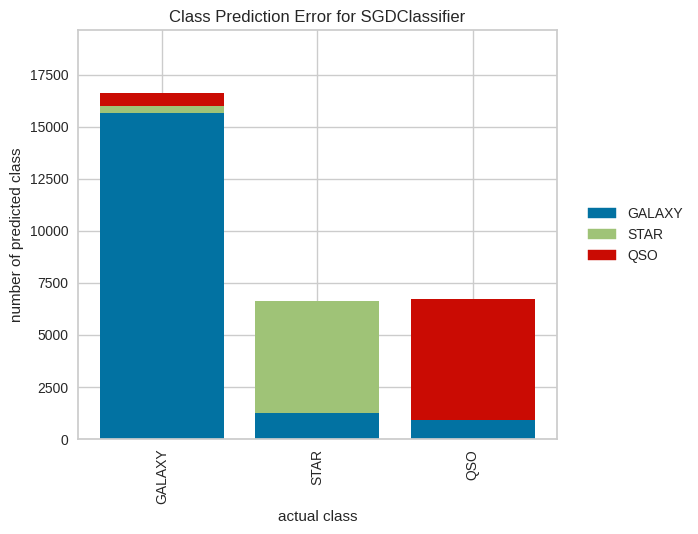

<Axes: title={'center': 'Class Prediction Error for SGDClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
class_prediction_error_default_SGD = ClassPredictionError(default_SGD, classes=['GALAXY','STAR','QSO'])

class_prediction_error_default_SGD.fit(X_train_smote, y_train_smote)
class_prediction_error_default_SGD.score(X_test, y_test)
class_prediction_error_default_SGD.show()

##Classification reports

###SVC

In [ ]:
#classification_report_trained_SVC = classification_report(y_test, y_preds_trained_SVC)
#print(classification_report_trained_SVC)

In [ ]:
#classification_report_default_SVC = classification_report(y_test, y_preds_default_SVC)
#print(classification_report_default_SVC)

###Linear Regression

In [ ]:
classification_report_trained_LR = classification_report(y_test, y_preds_trained_LR)
print(classification_report_trained_LR)

              precision    recall  f1-score   support

      GALAXY       0.66      0.08      0.14     17845
         QSO       0.30      0.69      0.42      5700
        STAR       0.28      0.64      0.39      6455

    accuracy                           0.32     30000
   macro avg       0.41      0.47      0.32     30000
weighted avg       0.51      0.32      0.25     30000



In [ ]:
classification_report_default_LR = classification_report(y_test, y_preds_default_LR)
print(classification_report_default_LR)

              precision    recall  f1-score   support

      GALAXY       0.71      0.17      0.27     17845
         QSO       0.31      0.68      0.42      5700
        STAR       0.30      0.62      0.41      6455

    accuracy                           0.36     30000
   macro avg       0.44      0.49      0.37     30000
weighted avg       0.54      0.36      0.33     30000



###KNN

In [ ]:
classification_report_trained_KNN = classification_report(y_test, y_preds_trained_KNN)
print(classification_report_trained_KNN)

              precision    recall  f1-score   support

      GALAXY       0.80      0.70      0.75     17845
         QSO       0.40      0.59      0.48      5700
        STAR       0.57      0.54      0.55      6455

    accuracy                           0.64     30000
   macro avg       0.59      0.61      0.59     30000
weighted avg       0.68      0.64      0.65     30000



In [ ]:
classification_report_default_KNN = classification_report(y_test, y_preds_default_KNN)
print(classification_report_default_KNN)

              precision    recall  f1-score   support

      GALAXY       0.78      0.76      0.77     17845
         QSO       0.42      0.51      0.46      5700
        STAR       0.59      0.53      0.56      6455

    accuracy                           0.66     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.67      0.66      0.67     30000



###Random Forest

In [ ]:
classification_report_trained_RF = classification_report(y_test, y_preds_trained_RF)
print(classification_report_trained_RF)

              precision    recall  f1-score   support

      GALAXY       0.97      0.95      0.96     17845
         QSO       0.88      0.92      0.90      5700
        STAR       0.98      1.00      0.99      6455

    accuracy                           0.96     30000
   macro avg       0.94      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



In [ ]:
classification_report_default_RF = classification_report(y_test, y_preds_default_RF)
print(classification_report_default_RF)

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     17845
         QSO       0.95      0.94      0.94      5700
        STAR       0.98      1.00      0.99      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000



###SGD Classifier

In [ ]:
classification_report_trained_SGD = classification_report(y_test, y_preds_trained_SGD)
print(classification_report_trained_SGD)

              precision    recall  f1-score   support

      GALAXY       0.97      0.94      0.96     17845
         QSO       0.86      0.93      0.89      5700
        STAR       0.98      1.00      0.99      6455

    accuracy                           0.95     30000
   macro avg       0.94      0.96      0.95     30000
weighted avg       0.95      0.95      0.95     30000



In [ ]:
classification_report_default_SGD = classification_report(y_test, y_preds_default_SGD)
print(classification_report_default_SGD)

              precision    recall  f1-score   support

      GALAXY       0.94      0.88      0.91     17845
         QSO       0.81      0.94      0.87      5700
        STAR       0.86      0.90      0.88      6455

    accuracy                           0.89     30000
   macro avg       0.87      0.91      0.89     30000
weighted avg       0.90      0.89      0.89     30000



##Roc curve and AUC score

###SVC

In [ ]:
#roc_trained_SVC = ROCAUC(trained_SVC, classes=['GALAXY','STAR','QSO'])

#roc_trained_SVC.fit(X_train_smote, y_train_smote)
#roc_trained_SVC.score(X_test, y_test)
#roc_trained_SVC.show()

In [ ]:
#roc_default_SVC = ROCAUC(default_SVC, classes=['GALAXY','STAR','QSO'])

#roc_default_SVC.fit(X_train_smote, y_train_smote)
#roc_default_SVC.score(X_test, y_test)
#roc_default_SVC.show()

###Logistic Regression

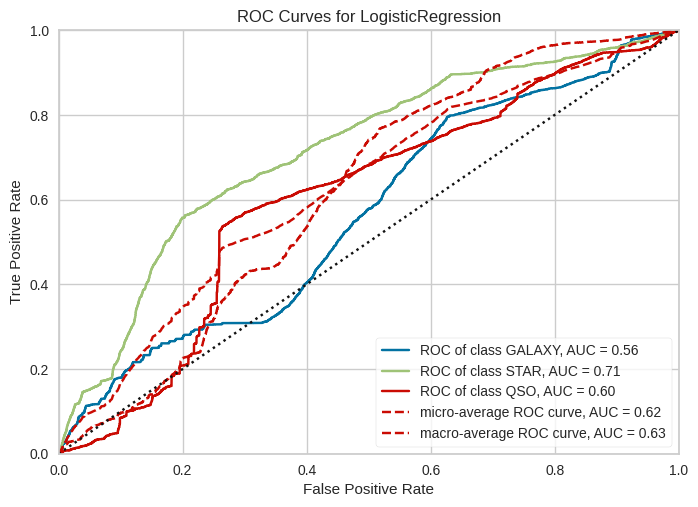

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_trained_LR = ROCAUC(trained_LR, classes=['GALAXY','STAR','QSO'])

roc_trained_LR.fit(X_train_smote, y_train_smote)
roc_trained_LR.score(X_test, y_test)
roc_trained_LR.show()

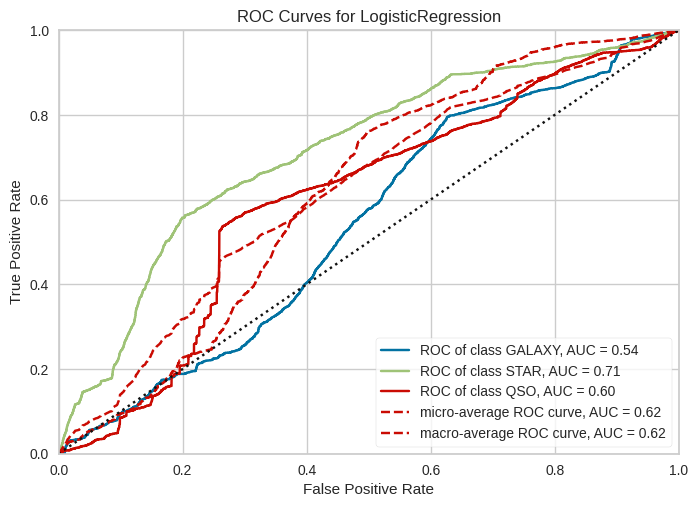

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_default_LR = ROCAUC(default_LR, classes=['GALAXY','STAR','QSO'])

roc_default_LR.fit(X_train_smote, y_train_smote)
roc_default_LR.score(X_test, y_test)
roc_default_LR.show()

###KNN

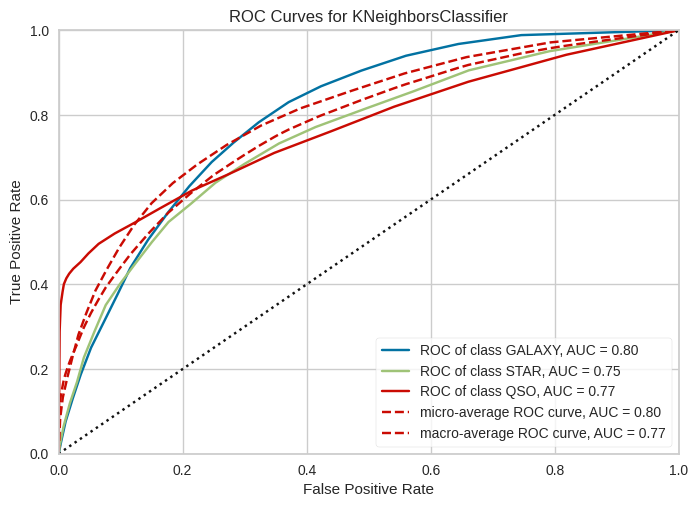

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_trained_KNN = ROCAUC(trained_KNN, classes=['GALAXY','STAR','QSO'])

roc_trained_KNN.fit(X_train_smote, y_train_smote)
roc_trained_KNN.score(X_test, y_test)
roc_trained_KNN.show()

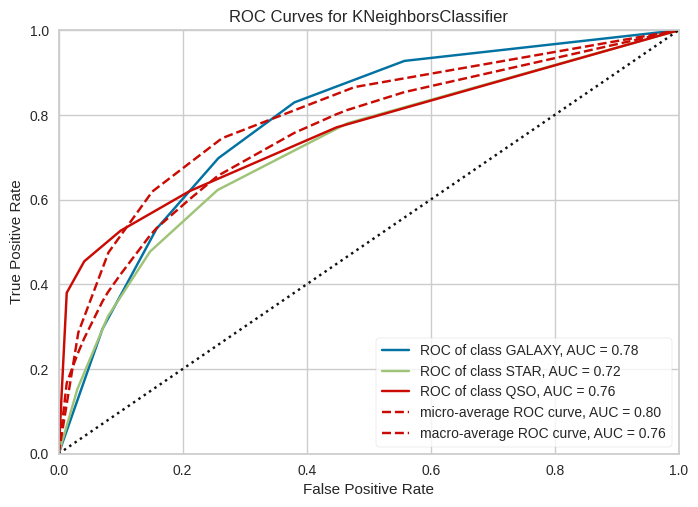

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_default_KNN = ROCAUC(default_KNN, classes=['GALAXY','STAR','QSO'])

roc_default_KNN.fit(X_train_smote, y_train_smote)
roc_default_KNN.score(X_test, y_test)
roc_default_KNN.show()

###Random Forest

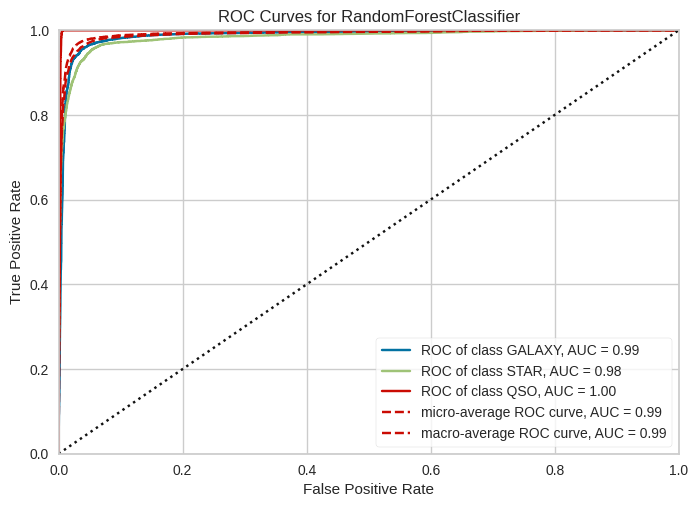

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_trained_RF = ROCAUC(trained_RF, classes=['GALAXY','STAR','QSO'])

roc_trained_RF.fit(X_train_smote, y_train_smote)
roc_trained_RF.score(X_test, y_test)
roc_trained_RF.show()

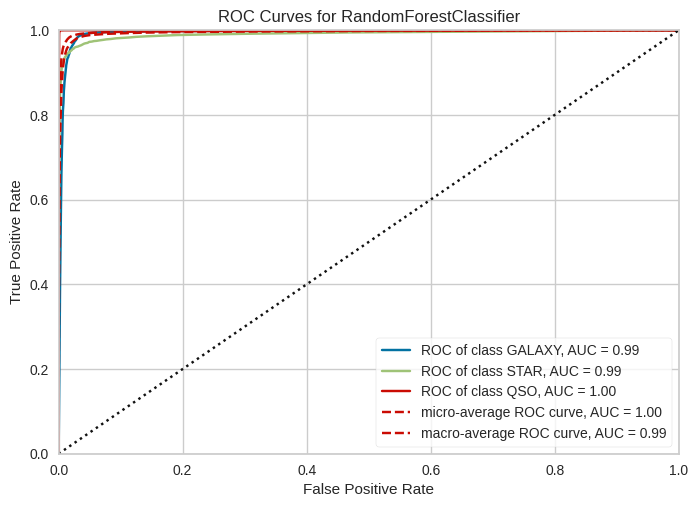

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_default_RF = ROCAUC(default_RF, classes=['GALAXY','STAR','QSO'])

roc_default_RF.fit(X_train_smote, y_train_smote)
roc_default_RF.score(X_test, y_test)
roc_default_RF.show()

###SGD Classifier

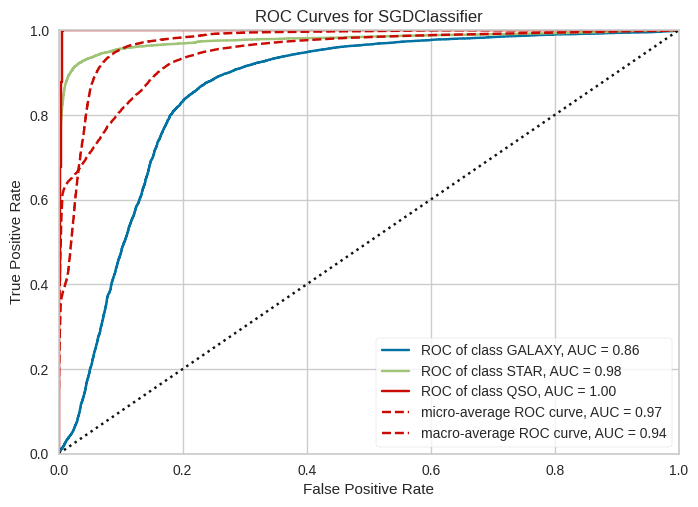

<Axes: title={'center': 'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_trained_SGD = ROCAUC(trained_SGD, classes=['GALAXY','STAR','QSO'])

roc_trained_SGD.fit(X_train_smote, y_train_smote)
roc_trained_SGD.score(X_test, y_test)
roc_trained_SGD.show()

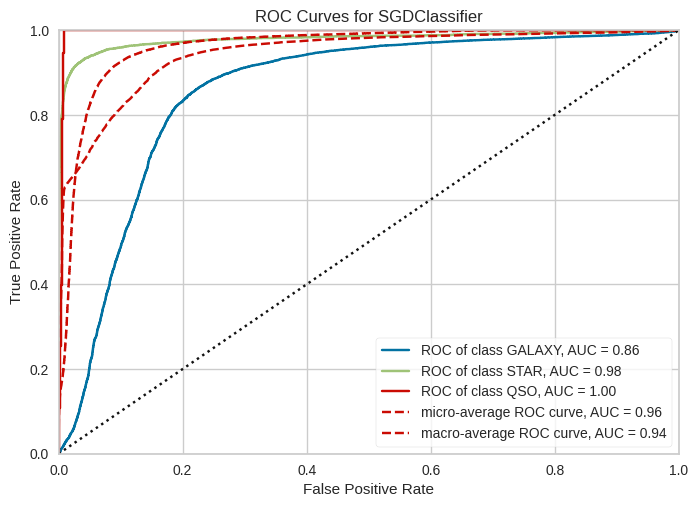

<Axes: title={'center': 'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
roc_default_SGD = ROCAUC(default_SGD, classes=['GALAXY','STAR','QSO'])

roc_default_SGD.fit(X_train_smote, y_train_smote)
roc_default_SGD.score(X_test, y_test)
roc_default_SGD.show()

##Cross-validation score

###SVC

In [ ]:
#cross_val_acc_trained_SVC = np.mean(cross_val_score(trained_SVC, X, y, scoring="accuracy", cv=5))
#cross_val_acc_default_SVC = np.mean(cross_val_score(default_SVC, X, y, scoring="accuracy", cv=5))

#print('trained_SVC score:', cross_val_acc_trained_SVC)
#print('default_SVC score:', cross_val_acc_default_SVC)

###Logistic Regression

In [ ]:
cross_val_acc_trained_LR = np.mean(cross_val_score(trained_LR, X, y, scoring="accuracy", cv=5))
cross_val_acc_default_LR = np.mean(cross_val_score(default_LR, X, y, scoring="accuracy", cv=5))

print('trained_LR score:', cross_val_acc_trained_LR)
print('default_LR score:', cross_val_acc_default_LR)

trained_LR score: 0.59842
default_LR score: 0.59947


###KNN

In [ ]:
cross_val_acc_trained_KNN = np.mean(cross_val_score(trained_KNN, X, y, scoring="accuracy", cv=5))
cross_val_acc_default_KNN = np.mean(cross_val_score(default_KNN, X, y, scoring="accuracy", cv=5))

print('trained_KNN score:', cross_val_acc_trained_KNN)
print('default_KNN score:', cross_val_acc_default_KNN)

trained_KNN scores: 0.68446 nan nan nan
default_KNN scores: 0.6627 nan nan nan


###Random Forest

In [ ]:
cross_val_acc_trained_RF = np.mean(cross_val_score(trained_RF, X, y, scoring="accuracy", cv=5))
cross_val_acc_default_RF = np.mean(cross_val_score(default_RF, X, y, scoring="accuracy", cv=5))

print('trained_RF score:', cross_val_acc_trained_RF)
print('default_RF score:', cross_val_acc_default_RF)

trained_RF scores: 0.9586100000000002 nan nan nan
default_RF scores: 0.9783999999999999 nan nan nan


###SGD Classifier

In [ ]:
cross_val_acc_trained_SGD = np.mean(cross_val_score(trained_SGD, X, y, scoring="accuracy", cv=5))
cross_val_acc_default_SGD = np.mean(cross_val_score(default_SGD, X, y, scoring="accuracy", cv=5))

print('trained_RF score:', cross_val_acc_trained_SGD)
print('default_RF score:', cross_val_acc_default_SGD)

trained_RF score: 0.94917
default_RF score: 0.9055300000000001
